In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
from esem import gp_model
import seaborn as sns
import cartopy.crs as ccrs
from gp_helpers_from_reproduction import *

import warnings

warnings.filterwarnings("ignore")

2024-02-06 16:47:34.622638: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-06 16:47:34.981630: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 16:47:34.981693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 16:47:35.004545: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 16:47:35.055731: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  2


In [3]:
files = ["ssp126", "ssp585", "historical", "hist-GHG"]
# Create training and testing arrays
X_train, pca_solvers = makeXTrain_PCASolvers(files)
y_train_tas = makeYTrain(files)['tas'].values.reshape(-1, 96 * 144)

X_test = makeXTest('ssp245', pca_solvers)
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
tas_truth = Y_test["tas"].mean('member')

In [4]:
# Removing NaNs 
nan_train_mask, nan_test_mask = X_train.isna().any(axis=1).values, X_test.isna().any(axis=1).values
X_train, X_test = X_train.dropna(axis=0, how='any'), X_test.dropna(axis=0, how='any')
y_train_tas, tas_truth = y_train_tas[~nan_train_mask], tas_truth[~nan_test_mask]

In [5]:
# Standardizing data for data that is not EOFs/PCA
X_train_CO2_mean, X_test_CO2_mean = X_train['CO2'].mean(), X_test['CO2'].mean()
X_train_CO2_std, X_test_CO2_std = X_train['CO2'].std(), X_test['CO2'].std()

X_train_CH4_mean, X_test_CH4_mean = X_train['CH4'].mean(), X_test['CH4'].mean()
X_train_CH4_std, X_test_CH4_std = X_train['CH4'].std(), X_test['CH4'].std()

X_train['CO2'] = (X_train['CO2'] - X_train_CO2_mean) / X_train_CO2_std
X_test['CO2'] = (X_test['CO2'] - X_test_CO2_mean) / X_test_CO2_std

X_train['CH4'] = (X_train['CH4'] - X_train_CH4_mean) / X_train_CH4_std
X_test['CH4'] = (X_test['CH4'] - X_test_CH4_mean) / X_test_CH4_std

# Standardizing y_train
y_train_tas_mean, y_train_tas_std = y_train_tas.mean(), y_train_tas.std()
y_train_tas = (y_train_tas - y_train_tas_mean) / y_train_tas_std

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt

import gpflow
import gpflux

from gpflow.config import default_float


In [7]:
num_data = len(X_train)
num_inducing = 10
output_dim = y_train_tas.shape[1]

kernel = gpflow.kernels.SquaredExponential()
inducing_variable = gpflow.inducing_variables.InducingPoints(
    np.linspace(X_train.min(), X_train.max(), num_inducing).reshape(-1, 1)
)
gp_layer = gpflux.layers.GPLayer(
    kernel, inducing_variable, num_data=num_data, num_latent_gps=output_dim
)

2024-02-06 16:47:55.599944: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8a:00.0, compute capability: 7.0
2024-02-06 16:47:55.600561: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31141 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0


In [8]:
likelihood = gpflow.likelihoods.Gaussian(0.01)

# So that Keras can track the likelihood variance, we need to provide the likelihood as part of a "dummy" layer:
likelihood_container = gpflux.layers.TrackableLayer()
likelihood_container.likelihood = likelihood

model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dense(1, activation="linear"),
        gp_layer,
        likelihood_container,  # no-op, for discovering trainable likelihood parameters
    ]
)
loss = gpflux.losses.LikelihoodLoss(likelihood)

In [9]:
model.compile(loss=loss, optimizer="adam")

Epoch 1/500


2024-02-06 16:48:08.828051: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x4216720
2024-02-06 16:48:09.005664: I external/local_xla/xla/service/service.cc:168] XLA service 0x152132f0b0a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-06 16:48:09.005703: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-02-06 16:48:09.005710: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-02-06 16:48:09.016677: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-06 16:48:09.058953: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1707263289.167430    1746 device_compiler.h:186] Compiled cluster using 

16/16 [==============================] - 9s 163ms/step - loss: 1307419.6250 - gp_layer_prior_kl: 1.0822
Epoch 2/500
16/16 [==============================] - 3s 163ms/step - loss: 918549.8750 - gp_layer_prior_kl: 7.0660
Epoch 3/500
16/16 [==============================] - 3s 163ms/step - loss: 798548.0000 - gp_layer_prior_kl: 20.1372
Epoch 4/500
16/16 [==============================] - 3s 162ms/step - loss: 692284.9375 - gp_layer_prior_kl: 36.1615
Epoch 5/500
16/16 [==============================] - 3s 162ms/step - loss: 594221.7500 - gp_layer_prior_kl: 54.9313
Epoch 6/500
16/16 [==============================] - 3s 162ms/step - loss: 508223.4688 - gp_layer_prior_kl: 78.8381
Epoch 7/500
16/16 [==============================] - 3s 162ms/step - loss: 438024.0000 - gp_layer_prior_kl: 106.1209
Epoch 8/500
16/16 [==============================] - 3s 163ms/step - loss: 385987.9375 - gp_layer_prior_kl: 135.1335
Epoch 9/500
16/16 [==============================] - 3s 162ms/step - loss: 347491.7

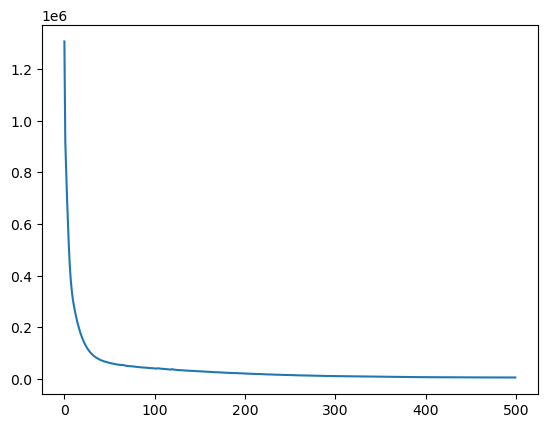

In [10]:
hist = model.fit(X_train, y_train_tas, epochs=500, verbose=1)
plt.plot(hist.history["loss"])

In [13]:
y_pred = model.predict(X_test.values)
y_pred.shape

3/3 [==============================] - 0s 27ms/step


(86, 13824)

In [16]:
y_pred = model.predict(X_test.values, full_cov=True)
y_pred.shape

TypeError: predict() got an unexpected keyword argument 'full_cov'

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1300      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
 gp_layer (GPLayer)          ((None, 13824),           102021242 
                              (None, 13824))                     
                                                                 
 trackable_layer (Trackable  (None, 13824)             1         
 Layer)                                                          
                                                                 
Total params: 102032744 (778.40 MB)
Trainable params: 10

In [37]:
temp = y_pred * y_train_tas_std + y_train_tas_mean
temp = np.reshape(temp, [86, 96, 144])
temp = xr.DataArray(temp, dims=tas_truth.dims, coords=tas_truth.coords)

In [38]:
def rmseFunc(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth - pred)**2).weighted(weights).mean(['lat', 'lon'])).data

In [39]:
RMSE_all = rmseFunc(tas_truth, temp).mean()
RMSE_all

0.9734461122238408

[Text(0.5, 1.0, 'Predictions')]

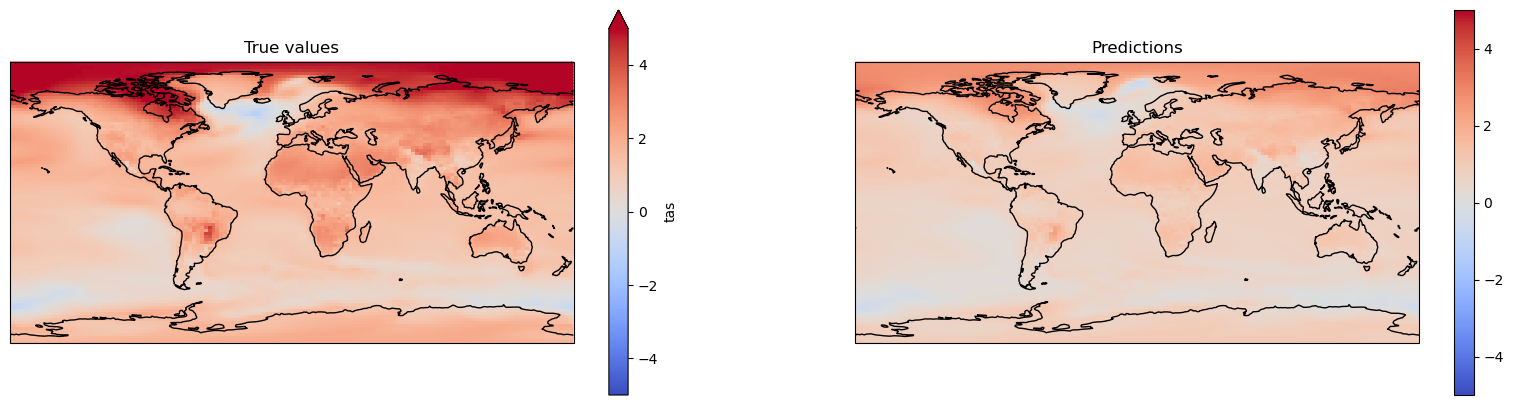

In [40]:
# plot the predictions vs the true values do last 20 years so not copying prof
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(20, 10))

# test plot
plt.subplot(1, 2, 1, projection=projection)
tas_truth.mean(dim='time').plot(
    transform=projection, cmap='coolwarm', vmin=-5, vmax=5, cbar_kwargs={'shrink': 0.5}
)

plt.gca().coastlines()
plt.setp(plt.gca(), title='True values')

# Predictions
plt.subplot(1, 2, 2, projection=projection)
temp.mean(dim='time').plot(
    transform=projection, cmap='coolwarm', vmin=-5, vmax=5, cbar_kwargs={'shrink': 0.5}
)

plt.gca().coastlines()
plt.setp(plt.gca(), title='Predictions')